In [1]:
!pip install --upgrade pip
!pip install imutils
!pip install opencv-python
!pip install --upgrade scikit-learn==0.23.0

  Attempting uninstall: pip
    Found existing installation: pip 20.2.2
    Uninstalling pip-20.2.2:


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Отказано в доступе: 'c:\\programdata\\anaconda3\\lib\\site-packages\\pip-20.2.2.dist-info\\entry_points.txt'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'c:\programdata\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\programdata\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\programdata\anaconda3\python.exe -m pip install --upgrade pip' command.


Requirement already up-to-date: scikit-learn==0.23.0 in c:\users\darde\appdata\roaming\python\python37\site-packages (0.23.0)


You should consider upgrading via the 'c:\programdata\anaconda3\python.exe -m pip install --upgrade pip' command.


Подключение базовых библиотек для обработки изображений

In [2]:
from IPython.display import Image
from imutils import paths
import numpy as np
import cv2
import os

Для работы с изображениями, найдем их гистограммы — характеристики распределения интенсивности изображения.

In [3]:
def extract_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

Считаем изображения из корневой папки train и вычислим гистограмму каждого изображения. Кроме того, отделим метку каждого изображения.

In [4]:
imagePaths = sorted(list(paths.list_images('train')))
trainData = []
labels = []

for (i, imagePath) in enumerate(imagePaths):
    image = cv2.imread(imagePath, 1)
    label = imagePath.split(os.path.sep)[-1].split(".")[0]
    hist = extract_histogram(image)
    trainData.append(hist)
    labels.append(label)

Преобразуем метки в удобный формат 0 и 1. Cat заменяем на 1, Dog на 0.

In [5]:
Y = [1 if x == 'cat' else 0 for x in labels]

1


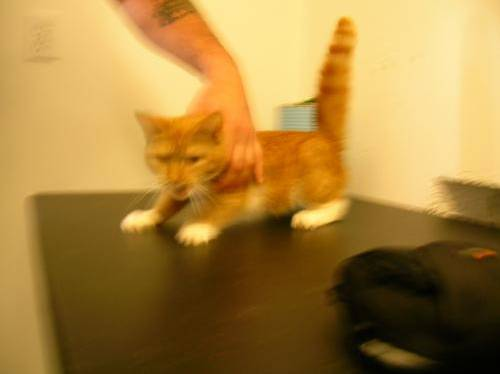

In [6]:
print(Y[0])
Image(filename=imagePaths[0])

Таким образом, классом 1 у нас занумерованы коты (кошки).

Обучим модель почти-разделяющий гиперплосоксти (Классификатор с мягким зазором).

In [7]:
from sklearn.svm import LinearSVC

svm = LinearSVC(random_state = 242, C = 1.21)
svm.fit(trainData, Y)

LinearSVC(C=1.21, random_state=242)

Бэггинг деревьев принятия решений.

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', #критерий разделения
                              min_samples_leaf=10, #минимальное число объектов в листе
                              max_leaf_nodes=20, #максимальное число листьев
                              random_state=242)
bagging = BaggingClassifier(tree, #базовый алгоритм
                            n_estimators=19, #количество деревьев
                            random_state=242)
bagging.fit(trainData, Y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_leaf_nodes=20,
                                                        min_samples_leaf=10,
                                                        random_state=242),
                  n_estimators=19, random_state=242)

обучаем третий базовый алгоритм — случайный лес

In [9]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=19, #количество деревьев
                             criterion='entropy', #критерий разделения
                              min_samples_leaf=10, #минимальное число объектов в листе
                              max_leaf_nodes=20, #максимальное число листьев
                              random_state=242)
forest.fit(trainData, Y)

RandomForestClassifier(criterion='entropy', max_leaf_nodes=20,
                       min_samples_leaf=10, n_estimators=19, random_state=242)

Задаем в качестве решающего метаалгоритма логистическую регрессию:

In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs', random_state=242)

Обучаем метаалгоритм

In [11]:
from sklearn.ensemble import StackingClassifier

base_estimators = [('SVM', svm), ('Bagging DT', bagging), ('DecisionForest', forest)]
sclf = StackingClassifier(estimators=base_estimators, final_estimator=lr, cv=2)
sclf.fit(trainData, Y)

StackingClassifier(cv=2,
                   estimators=[('SVM', LinearSVC(C=1.21, random_state=242)),
                               ('Bagging DT',
                                BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                        max_leaf_nodes=20,
                                                                                        min_samples_leaf=10,
                                                                                        random_state=242),
                                                  n_estimators=19,
                                                  random_state=242)),
                               ('DecisionForest',
                                RandomForestClassifier(criterion='entropy',
                                                       max_leaf_nodes=20,
                                                       min_samples_leaf=10,
       

Оценка метамодели. Доля правильной классификации (Accuracy):

In [12]:
sclf.score(trainData, Y) #0.848

0.852

Вычислим предсказания для объектов из папки test

In [13]:
singleImage = cv2.imread('test/cat.1025.jpg')
histt = extract_histogram(singleImage)
histt2 = histt.reshape(1, -1)
sclf.predict_proba(histt2)

array([[0.31887771, 0.68112229]])

In [14]:
singleImage = cv2.imread('test/dog.1013.jpg')
histt = extract_histogram(singleImage)
histt2 = histt.reshape(1, -1)
sclf.predict_proba(histt2)

array([[0.89888915, 0.10111085]])

In [15]:
singleImage = cv2.imread('test/dog.1030.jpg')
histt = extract_histogram(singleImage)
histt2 = histt.reshape(1, -1)
sclf.predict_proba(histt2)

array([[0.63414443, 0.36585557]])

In [16]:
singleImage = cv2.imread('test/dog.1041.jpg')
histt = extract_histogram(singleImage)
histt2 = histt.reshape(1, -1)
sclf.predict_proba(histt2)

array([[0.63667927, 0.36332073]])